# Gaussian Belief Propagation using Markov Random Field

## Explain the `run_GaBP(A, b)` Function
- This notebook based on the `run_GaBP(A, b)` Function, which implements the
  Gaussian Belief Propagation algorithm using Markov Random Field.

- The core of the function relies on `calc_m_ij` for updating the messages during the algorithm and
  on `calc_node_marginal` which called at the end of the iterations to infer the marginals.

- The function used matrices as it's main datatype, while using masking with `numpy` to minimize operations on zero
  elements as it is assumed the matrices are sparse.

- As `numpy` interacts nicely with `numba`, all the algorithm is implemented using `numba` optimization.
    - That's why the algorithm using functions and not a class.
    - I checked the performance with and without it, and it seems to make the code about 10 times faster on my machine.
      However, more in depth look is needed.


- _Input_:
    - $A$ - the data matrix
    - $b$ - the observation vector
- _Output_:
    - $P_i$ - Marginal precisions. Given by: $P_i = P_{ii}+  \sum_{k \in N\left ( i \right )} P_{ki} $.
    - $\mu_i$ - Marginal means. Given by: $\mu_i = \frac{P_{ii}\mu_{ii}+  \sum_{k \in N\left ( i \right )} P_{ki}\mu_{ki}}{P_i}$.
    - $N_i$ - Node neighbors. Given by: $N\left ( i \right ) = \left \{ k | k\neq i, A_{ki} \neq 0 \right \}$.
    - $P_{ii}$ - initialized by: $P_{ii}=A_{ii}$.
      Doesn't change during the algorithm.
    - $\mu_{ii}$ - initialized by: $\mu_{ii}=\frac{b_i}{A_{ii}}$.
      Doesn't change during the algorithm.
    - $P_{ij}$ - initialized by: $P_{ij}=0$.
      Changed during the algorithm on each iteration by: $P_{ij} = -A_{ij}^2 P_{i\setminus j}^{-1}$
    - $\mu_{ij}$ - initialized by: $\mu_{ij}=0$.
      Changed during the algorithm on each iteration by: $\mu _{ij}=-P_{ij}^{-1} A_{ij} \mu_{i\setminus j}$
    - `iter_dist` - the $L2$ change of $P_{ij}$ and $\mu_{ij}$ after each iteration.
    Used to check the convergence of the algorithm

While $P_{ii}$, $\mu_{ii}$ used to find the node potential and $P_{ij}$, $\mu_{ij}$ used to find the nodes messages
using:
- Node potential:
$ \phi_i\left ( x_i \right )\propto {N}\left ( \mu_{ii}=\frac{b_i}{A_{ii}}, P_{ii}^{-1}=A_{ii}^{-1} \right )  $
- Node messages:
$m_{ij}\left ( x_{j} \right ) \propto N\left ( \mu_{ij}, P_{ij}^{-1} \right )$

## Setup

In [1]:
%config InlineBackend.figure_format = 'svg'

from time import time

from src.synthetic_data import DataGenerator
from src.gabp_mrf import run_GaBP
from src.visualization import set_plot_options, get_plot_colors, NetworkxGraph, AnalyzeResult
from src.utils import HiddenPrints

set_plot_options()
colors = get_plot_colors()

data_gen = DataGenerator()
result_analyzer = AnalyzeResult()

> Numba compiles the code to C, so the first time calling an optimized function takes a few seconds.
>
> Therefore, force it to compile early on a small example so time measurements later won't be affected by the
> compilation time.

In [2]:
with HiddenPrints():
    A, b = data_gen.get_sparse_tree_matrix(dim=500)
    P_i, mu_i, N_i, P_ii, mu_ii, P_ij, mu_ij, iter_dist = run_GaBP(A, b, max_iter=100, convergence_threshold=1e-5)

## Get Random Data

In [3]:
num_nodes = 500
A, b = data_gen.get_sparse_tree_matrix(dim=num_nodes)

print(f'The data matrix A with shape of: {A.shape}')
print(f'The observation vector b with shape of: {b.shape}')


The data matrix A with shape of: (500, 500)
The observation vector b with shape of: (500,)


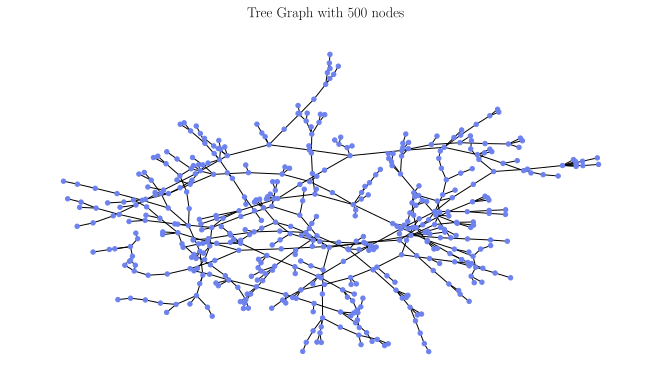

In [4]:
graph = NetworkxGraph(A)
graph.draw_graph(title=f'Tree Graph with {num_nodes} nodes', color=colors[0])

## Run the Algorithm

In [5]:
print('=> Running GaBP on the graph')
start_time = time()

P_i, mu_i, N_i, P_ii, mu_ii, P_ij, mu_ij, iter_dist = run_GaBP(A, b, max_iter=100, convergence_threshold=1e-5)

end_time = time()
dt = (end_time - start_time)*1000
print(f'=> Running Time: {dt :0.2f}[ms]')

=> Running GaBP on the graph
=> Converged after iteration 15
=> Running Time: 24.59[ms]


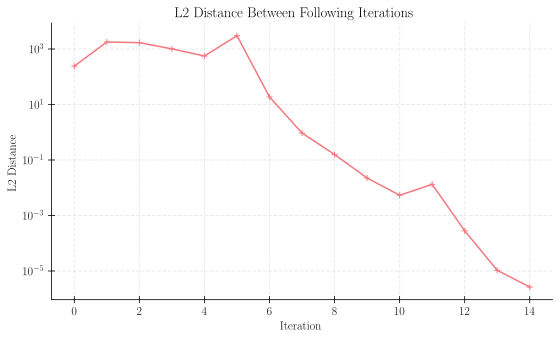

In [6]:
result_analyzer.plot_gabp_convergence(iter_dist, color=colors[3])

### Compare Run Times for Different Number of Nodes

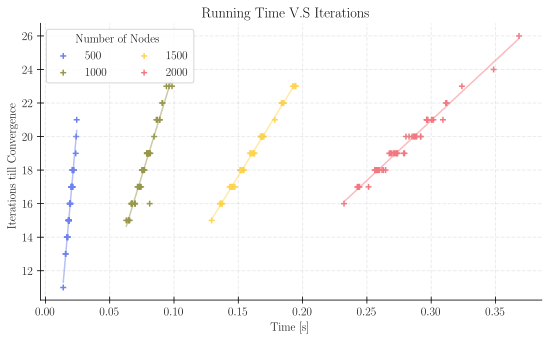

In [7]:
result_analyzer.plot_time_vs_iterations(num_iters=50, dims=[500, 1000, 1500, 2000])

## Check Results on Loopy (Non-Tree) Graph
We begin with a given tree graph which was implemented before. In order to create loopy graph, but still control
how 'not tree' it is, two parameters are used:
1. `max_loops` - Maximum amount of loops to add. To add a loop, take 2 edges `[node1, node2]` and `[node3, node4]` and
connect all the nodes by putting random non-zero value in it's place in the data matrix $A$.
Note that if for example the chosen edges
are `[1, 2]` and `[2, 1]` nothing will happen as they are already connected (that's why the parameter gives the maximum
number of loops but not the exact number).
2. `max_drop_edges` - Maximum amount of edges to drop. Randomly choose `max_drop_edges` edges and drop from the graph,
trying to create "islands" in the graph.

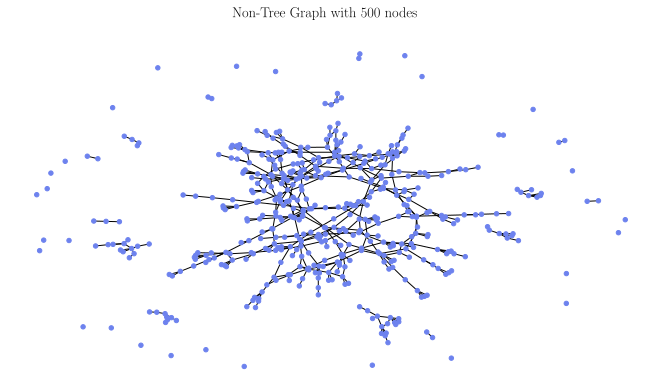

In [8]:
num_nodes = 500
max_loops = 30
max_drop_edges = 75

A, b = data_gen.get_sparse_tree_matrix(dim=num_nodes)
A = data_gen.add_loops_to_A(A, max_loops)
A = data_gen.cut_random_edges(A, max_drop_edges)

graph = NetworkxGraph(A)
graph.draw_graph(title=f'Non-Tree Graph with {num_nodes} nodes', color=colors[0])

In [9]:
print('=> Running GaBP on the graph')
start_time = time()
P_i, mu_i, N_i, P_ii, mu_ii, P_ij, mu_ij, iter_dist = run_GaBP(A, b, max_iter=500, convergence_threshold=1e-5)
end_time = time()
dt = (end_time - start_time)*1000
print(f'=> Running Time: {dt :0.2f}[ms]')

=> Running GaBP on the graph
=> Converged after iteration 14
=> Running Time: 21.32[ms]


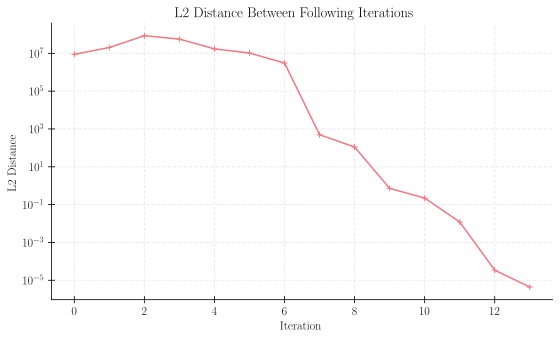

In [10]:
result_analyzer.plot_gabp_convergence(iter_dist, color=colors[3])
